In [469]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [470]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
import numpy as np
import hockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time
from dotenv import load_dotenv
load_dotenv('../.env')

from custom_sb3.replay_buffer import EREBuffer
import matplotlib.pyplot as plt

In [471]:
np.set_printoptions(suppress=True)

In [472]:
reload(h_env)

c:\Machine Learning\Master Tuebingen\Semester_3\RL\.venv\Lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Machine Learning\Master Tuebingen\Semester_3\RL\.venv\Lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'hockey.hockey_env' from 'c:\\Machine Learning\\Master Tuebingen\\Semester_3\\RL\\.venv\\Lib\\site-packages\\hockey\\hockey_env.py'>

In [475]:
env = h_env.HockeyEnv()

In [476]:
buffer_size = 500  # Increased buffer size to see clearer distribution
cmin = 25  # Minimum number of recent samples (adjusted to buffer size)
eta0 = 0.996  # Still aggressive decay to emphasize recent samples
etaT = 1

device = "cpu"

ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta0,
    etaT=etaT,
    total_timesteps=buffer_size*10,
    cmin=cmin
)
batch_size = 8
K = 10

Using EREBuffer with: eta0=0.996, etaT=1, cmin=25, total_timesteps=5000


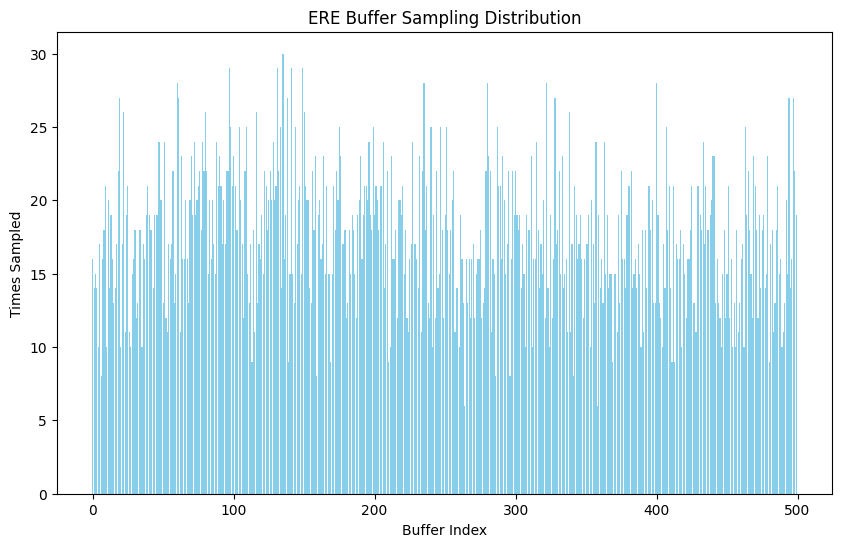

In [478]:
sample_counts = {i: 0 for i in range(buffer_size)}

obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(buffer_size*10):  # More than buffer_size to ensure wrap-around
    a1 = np.random.uniform(-1, 1, 4)
    a2 = np.random.uniform(-1, 1, 4)
    
    obs, r, d, t, info = env.step(np.hstack([a1, a2]))
    obs_agent2 = env.obs_agent_two()

    ere_buffer.add(
        obs=np.array(obs),  
        next_obs=np.array(obs_agent2),  
        action=np.hstack([a1, a2]),  
        reward=np.array([r]),  
        done=np.array([d]),  
        infos=[info] 
    )

    # Sample every 10 steps to track behavior
    if i % 50 == 0 and i>0:  # and i >= ere_buffer.buffer_size
        for k in range(0,K+1):
            sampled_indices = ere_buffer._sample_recent(batch_size, ere_buffer.size(), k=k, K=K, current_timestep=i)
            # Track sampled indices
            for idx in sampled_indices:
                sample_counts[idx] += 1

indices = list(sample_counts.keys())
counts = list(sample_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(indices, counts, color='skyblue')
plt.xlabel("Buffer Index")
plt.ylabel("Times Sampled")
plt.title("ERE Buffer Sampling Distribution")
plt.show()


No Buffer Index should be prefered!

#### More Recent Samples are favored; The lower eta the stronger is this effect

In [492]:
buffer_size = 5000 # 1_000_000 in original paper
cmin = 50 # 5000 in original
eta0 = 0.9 # 0.996 in original
etaT = eta0
device = "cpu"    

batch_size = 12 # 256 in original
K = 50 # 1000 in original

Using EREBuffer with: eta0=0.996, etaT=0.996, cmin=50, total_timesteps=20000
Using EREBuffer with: eta0=0.99, etaT=0.99, cmin=50, total_timesteps=20000
Using EREBuffer with: eta0=0.95, etaT=0.95, cmin=50, total_timesteps=20000
Using EREBuffer with: eta0=0.9, etaT=0.9, cmin=50, total_timesteps=20000


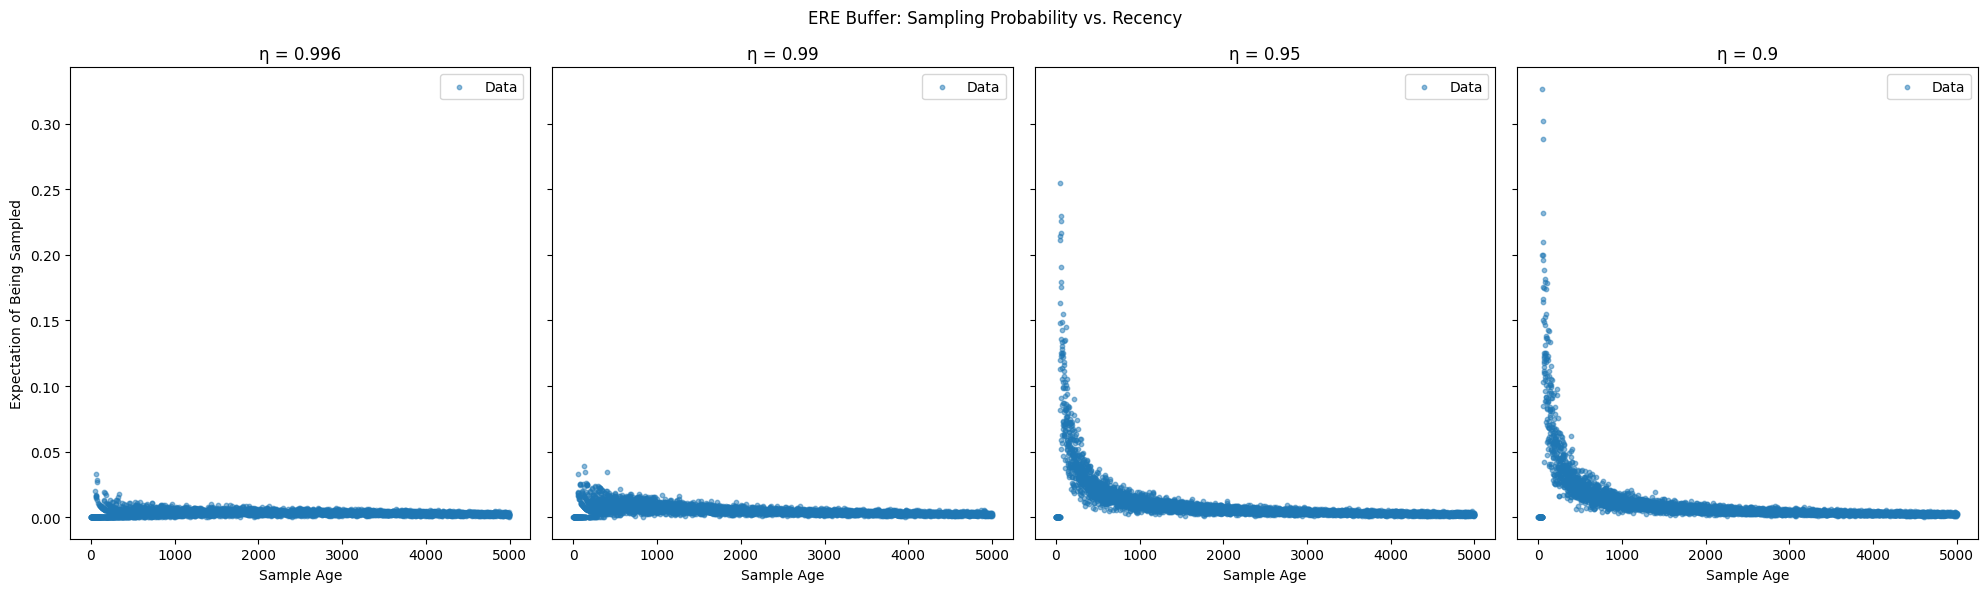

In [493]:
eta_values = [0.996, 0.99, 0.95, 0.9]
fig, axes = plt.subplots(1, len(eta_values), figsize=(20, 6), sharey=True)

for ax, eta in zip(axes, eta_values):
    # Track how often each unique sample is sampled
    ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta,
    etaT=eta, # NO ANNEALING USED HERE TO SEE EFFECT OF eta
    cmin=cmin,
    total_timesteps=buffer_size*4
)

    sample_counts = {}
    timestep_mapping = {}

    obs, info = env.reset()
    obs_agent2 = env.obs_agent_two()

    for i in range(buffer_size*4):  
        a1 = np.random.uniform(-1, 1, 4)
        a2 = np.random.uniform(-1, 1, 4)
        
        obs, r, d, t, info = env.step(np.hstack([a1, a2]))
        obs_agent2 = env.obs_agent_two()

        ere_buffer.add(
            obs=np.array(obs),  
            next_obs=np.array(obs_agent2),  
            action=np.hstack([a1, a2]),  
            reward=np.array([r]),  
            done=np.array([d]),
            infos=[info]
        )

        buf_idx = (ere_buffer.pos - 1) % ere_buffer.buffer_size # wrap around

        if buf_idx in timestep_mapping:
            old_timestep = timestep_mapping[buf_idx]
            if old_timestep in sample_counts:
                # Keep track of unique samples not indices!
                del sample_counts[old_timestep]  

        timestep_mapping[buf_idx] = i
        sample_counts[i] = 0  

        if i % K == 0 and i > 0:
            for k in range(K):
                upper_bound = ere_buffer.size() 
                sampled_indices = ere_buffer._sample_recent(batch_size, upper_bound, k=k, K=K, current_timestep=i)

                for buf_idx in sampled_indices:
                    timestep = timestep_mapping[buf_idx]
                    sample_counts[timestep] += 1

    # Compute expectation of being sampled
    expectation_counts = {}
    for timestep in sample_counts:
        sample_age = i - timestep  
        if sample_age > 0:  
            expectation_counts[sample_age] = sample_counts[timestep] / sample_age

    # Sort for plotting
    recencies = np.array(sorted(expectation_counts.keys()))
    expectations = np.array([expectation_counts[r] for r in recencies])

    # Scatter plot
    ax.scatter(recencies, expectations, alpha=0.5, s=10, label="Data")

    # ax.set_yscale("log")
    ax.set_xlabel("Sample Age")
    ax.set_title(f"η = {eta}")
    ax.legend()

axes[0].set_ylabel("Expectation of Being Sampled")
plt.suptitle("ERE Buffer: Sampling Probability vs. Recency")
plt.tight_layout()
plt.show()


The earliest samples seem to have expectation of zero since there was no "gradient step"/sampling step since they were added
(Updates occur at if i % K == 0 and i > 0)

In [488]:
buffer_size = 5000 # 1_000_000
cmin = 50 # 5000
eta0 = 0.95
etaT = 0.95
device = "cpu"

# Initialize EREBuffer
ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta0,
    etaT=etaT,
    total_timesteps=buffer_size*4,
    cmin=cmin
)

batch_size = 12 # 256
K = 50 # 1000

Using EREBuffer with: eta0=0.95, etaT=0.95, cmin=50, total_timesteps=20000


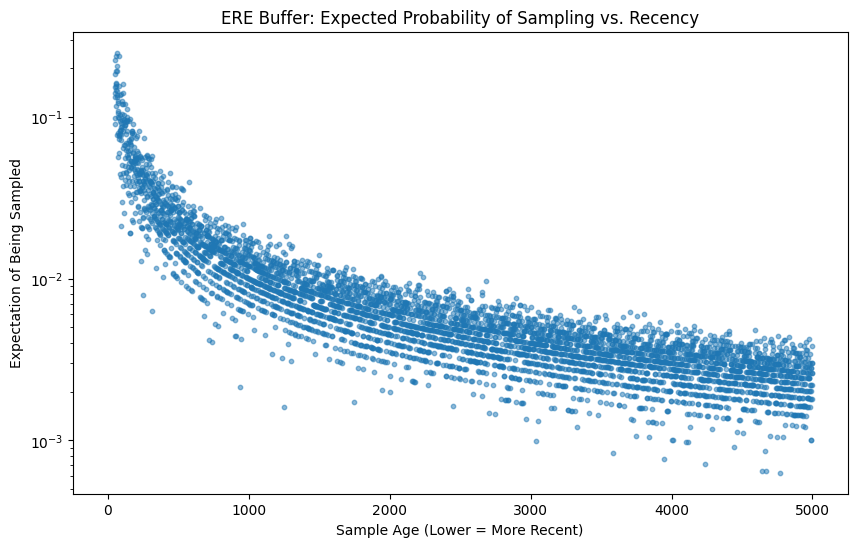

In [489]:
# Track how often each unique sample is sampled
sample_counts = {}

# Track insertion timestep for each sample
timestep_mapping = {}

obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(buffer_size*4):  # Ensure enough steps to see full buffer behavior
    a1 = np.random.uniform(-1, 1, 4)
    a2 = np.random.uniform(-1, 1, 4)
    
    obs, r, d, t, info = env.step(np.hstack([a1, a2]))
    obs_agent2 = env.obs_agent_two()

    ere_buffer.add(
        obs=np.array(obs),  
        next_obs=np.array(obs_agent2),  
        action=np.hstack([a1, a2]),  
        reward=np.array([r]),  
        done=np.array([d]),
        infos=[info]
    )

    # Determine where in the buffer the sample will be stored
    buf_idx = (ere_buffer.pos - 1) % ere_buffer.buffer_size # to handle wrap-around

    # If overwriting an old sample, reset its sample count
    if buf_idx in timestep_mapping:
        old_timestep = timestep_mapping[buf_idx]
        if old_timestep in sample_counts:
            del sample_counts[old_timestep]  # Remove old sample from tracking

    # Store the new sample's insertion timestep
    timestep_mapping[buf_idx] = i
    sample_counts[i] = 0  # Start counting from 0 for this new sample

    # Sample every 10 steps
    if i % K == 0 and i > 0:
        for k in range(K):
            upper_bound = ere_buffer.size() 
            sampled_indices = ere_buffer._sample_recent(batch_size, upper_bound, k=k, K=K, current_timestep=i)

            for buf_idx in sampled_indices:
                timestep = timestep_mapping[buf_idx]  # Get unique sample's timestep
                sample_counts[timestep] += 1
# Compute expected probability of being drawn
expectation_counts = {}

for timestep in sample_counts:
    sample_age = i - timestep  # How long the sample has existed
    if sample_age > 0:  # Avoid division by zero
        expectation_counts[sample_age] = sample_counts[timestep] / sample_age

# Sort for plotting
recencies = sorted(expectation_counts.keys())  
expectations = [expectation_counts[r] for r in recencies]

plt.figure(figsize=(10, 6))
# plt.plot(recencies, expectations, marker='o', linestyle='-', color='red')
plt.scatter(recencies, expectations, alpha=0.5, s=10)
plt.xlabel("Sample Age (Lower = More Recent)")
plt.yscale('log')
plt.ylabel("Expectation of Being Sampled")
plt.title("ERE Buffer: Expected Probability of Sampling vs. Recency")
plt.show()

#### Decreasing of Sampling size c_k

In [ ]:
buffer_size = 5000  # Increased buffer size to see clearer distribution
cmin = 125  # Minimum number of recent samples (adjusted to buffer size)
eta0 = 0.996  
etaT = eta0
batch_size = 28
K = 50

device = "cpu"

ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta0,
    etaT=etaT,
    cmin=cmin,
    total_timesteps=buffer_size*10
)

k_counts = {k: 0 for k in range(1, K)} # map k to sample_sizes (c_k)
no_updates = 0

obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(buffer_size*10):  # More than buffer_size to ensure wrap-around
    a1 = np.random.uniform(-1, 1, 4)
    a2 = np.random.uniform(-1, 1, 4)
    
    obs, r, d, t, info = env.step(np.hstack([a1, a2]))
    obs_agent2 = env.obs_agent_two()

    ere_buffer.add(
        obs=np.array(obs),  
        next_obs=np.array(obs_agent2),  
        action=np.hstack([a1, a2]),  
        reward=np.array([r]),  
        done=np.array([d]),  
        infos=[info] 
    )

    # Sample every 10 steps to track behavior
    if i % K == 0: #and i >= ere_buffer.buffer_size:
        no_updates += 1
        for k in range(1,K):
            ck = max(int(ere_buffer.size() * (eta0 ** (k * 250 / K ))), cmin) 
            k_counts[k] += ck

Using EREBuffer with: eta0=0.996, etaT=0.996, cmin=125, total_timesteps=50000


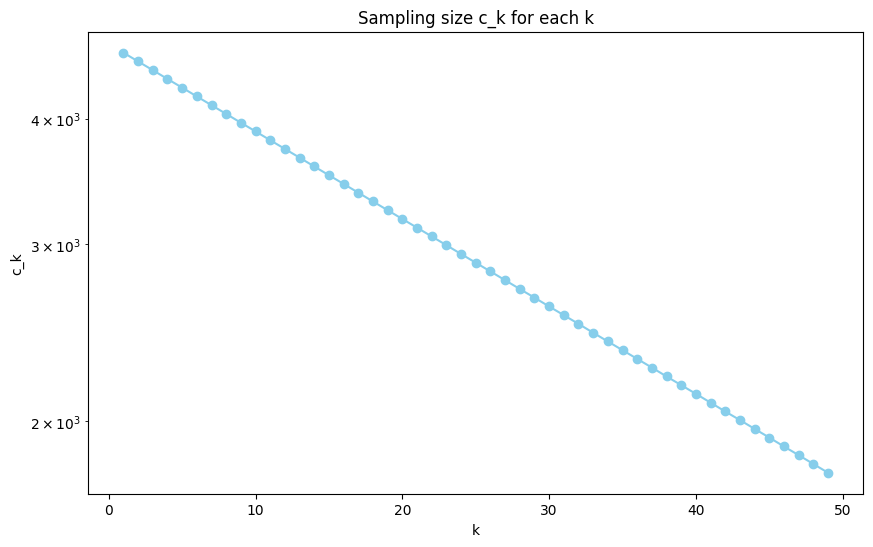

In [497]:
indices = list(k_counts.keys())
counts = [k_counts[k] / no_updates for k in k_counts]

plt.figure(figsize=(10, 6))
plt.plot(indices, counts, color='skyblue', marker='o')
plt.xlabel("k")
plt.yscale('log')
plt.ylabel("c_k")
plt.title("Sampling size c_k for each k")
plt.show()

### Annealing of eta

In [514]:
buffer_size = 5000  # Increased buffer size to see clearer distribution
cmin = 125  # Minimum number of recent samples (adjusted to buffer size)
eta0 = 0.996  
etaT = 1
batch_size = 28
K = 50

device = "cpu"
total_timesteps = buffer_size*2
max_eps_length = 250

In [512]:
ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta0,
    etaT=etaT,
    cmin=cmin,
    total_timesteps=total_timesteps
)

k_counts = {k: 0 for k in range(1, K)} # map k to sample_sizes (c_k)
no_updates = 0

obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

etas = []

for i in range(total_timesteps):  # More than buffer_size to ensure wrap-around
    a1 = np.random.uniform(-1, 1, 4)
    a2 = np.random.uniform(-1, 1, 4)
    
    obs, r, d, t, info = env.step(np.hstack([a1, a2]))
    obs_agent2 = env.obs_agent_two()

    ere_buffer.add(
        obs=np.array(obs),  
        next_obs=np.array(obs_agent2),  
        action=np.hstack([a1, a2]),  
        reward=np.array([r]),  
        done=np.array([d]),  
        infos=[info] 
    )

    # Sample every 10 steps to track behavior
    if i % K == 0:
        no_updates += 1
        eta = ere_buffer.get_eta(i)
        etas.append(eta)

Using EREBuffer with: eta0=0.996, etaT=1, cmin=125, total_timesteps=10000


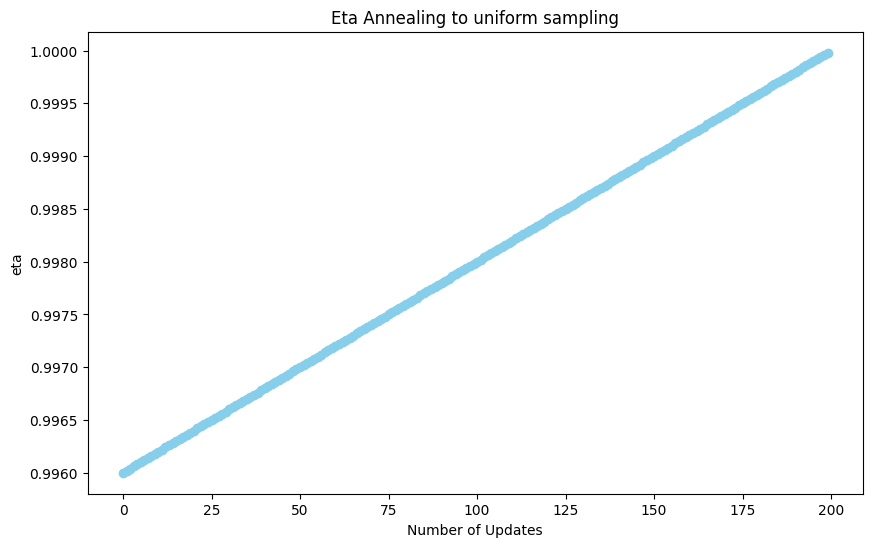

In [513]:
plt.figure(figsize=(10, 6))
plt.plot(etas, color='skyblue', marker='o')
plt.xlabel("Number of Updates")
plt.ylabel("eta")
plt.title("Eta Annealing to uniform sampling")
plt.show()

Using EREBuffer with: eta0=0.996, etaT=1, cmin=125, total_timesteps=50000


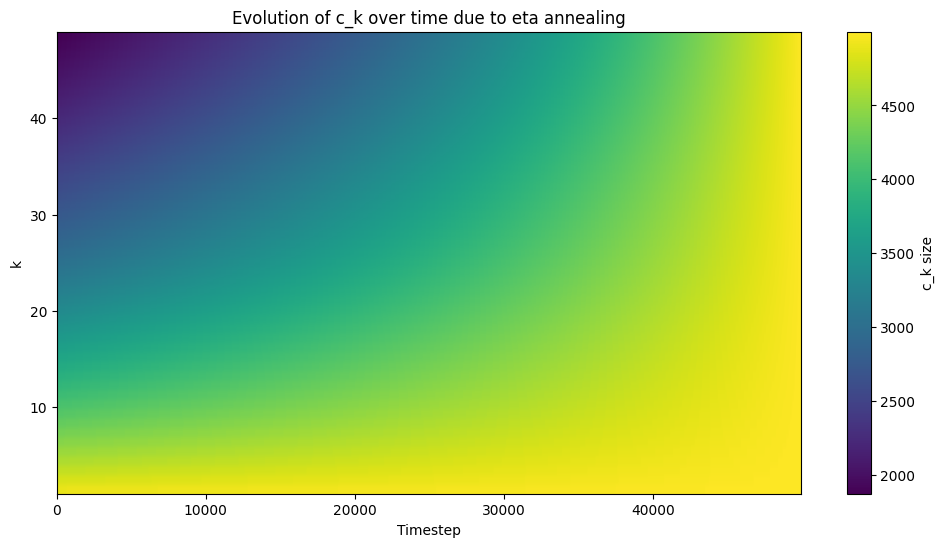

In [ ]:
total_timesteps = buffer_size * 10

ere_buffer = EREBuffer(
    buffer_size=buffer_size,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=device,
    eta0=eta0,
    etaT=etaT,
    cmin=cmin,
    total_timesteps=total_timesteps
)

# Simulate eta annealing and c_k values over time
timesteps = np.arange(0, total_timesteps, K)  # Sample every K steps
etas = [ere_buffer.get_eta(t) for t in timesteps]
k_values = np.arange(1, K)

# Compute c_k values over time
c_k_over_time = np.zeros((len(timesteps), len(k_values)))

for t_idx, eta in enumerate(etas):
    for k_idx, k in enumerate(k_values):
        c_k_over_time[t_idx, k_idx] = max(int(buffer_size * (eta ** (k * max_eps_length / K))), cmin)

# Plot heatmap of c_k values over time
plt.figure(figsize=(12, 6))
plt.imshow(c_k_over_time.T, aspect='auto', cmap='viridis', origin='lower', 
           extent=[timesteps[0], timesteps[-1], k_values[0], k_values[-1]])

plt.colorbar(label='c_k size')
plt.xlabel("Timestep")
plt.ylabel("k")
plt.title("Evolution of c_k over time due to eta annealing")
plt.show()


Eta is annealing to uniform sampling!